In [ ]:
!pip install segmentation-models-pytorch --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=6cbf02e1cc2c59f927121d33ea66e6a306fe5c448ddec03ae1413a6dd625abcf
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=d4357bb453a0b4f7d380a19208e02b7362a73128f04c8ea823d732b5fe6809b8
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
!pip install segmentation-models-pytorch

In [ ]:
!pip install  pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 35.2 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from torch import nn
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMAGE_SIZE = 320
BATCH_SIZE = 16
EPOCHS = 5

color_dict = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/land_classification/class_dict.csv')
CLASSES = color_dict['name']
print(color_dict)

               name    r    g    b
0        urban_land    0  255  255
1  agriculture_land  255  255    0
2         rangeland  255    0  255
3       forest_land    0  255    0
4             water    0    0  255
5       barren_land  255  255  255
6           unknown    0    0    0


In [ ]:
from glob import glob
from sklearn.utils import shuffle

pd_dataset = pd.DataFrame({
    'IMAGES': sorted(glob("/content/drive/MyDrive/Colab_Notebooks/land_classification/train/*.jpg")),
    'MASKS': sorted(glob("/content/drive/MyDrive/Colab_Notebooks/land_classification/train/*.png"))
})
pd_dataset = shuffle(pd_dataset)
pd_dataset.reset_index(inplace=True, drop=True)
pd_dataset.head()

,IMAGES,MASKS
0,/content/drive/MyDrive/Colab_Notebooks/land_cl...,/content/drive/MyDrive/Colab_Notebooks/land_cl...
1,/content/drive/MyDrive/Colab_Notebooks/land_cl...,/content/drive/MyDrive/Colab_Notebooks/land_cl...
2,/content/drive/MyDrive/Colab_Notebooks/land_cl...,/content/drive/MyDrive/Colab_Notebooks/land_cl...
3,/content/drive/MyDrive/Colab_Notebooks/land_cl...,/content/drive/MyDrive/Colab_Notebooks/land_cl...
4,/content/drive/MyDrive/Colab_Notebooks/land_cl...,/content/drive/MyDrive/Colab_Notebooks/land_cl...


In [ ]:
from sklearn.model_selection import train_test_split

pd_train, pd_test = train_test_split(pd_dataset, test_size=0.25, random_state=0)
pd_train, pd_val = train_test_split(pd_train, test_size=0.2, random_state=0)

print("Training set size:", len(pd_train))
print("Validation set size:", len(pd_val))
print("Testing set size:", len(pd_test))

Training set size: 481
Validation set size: 121
Testing set size: 201


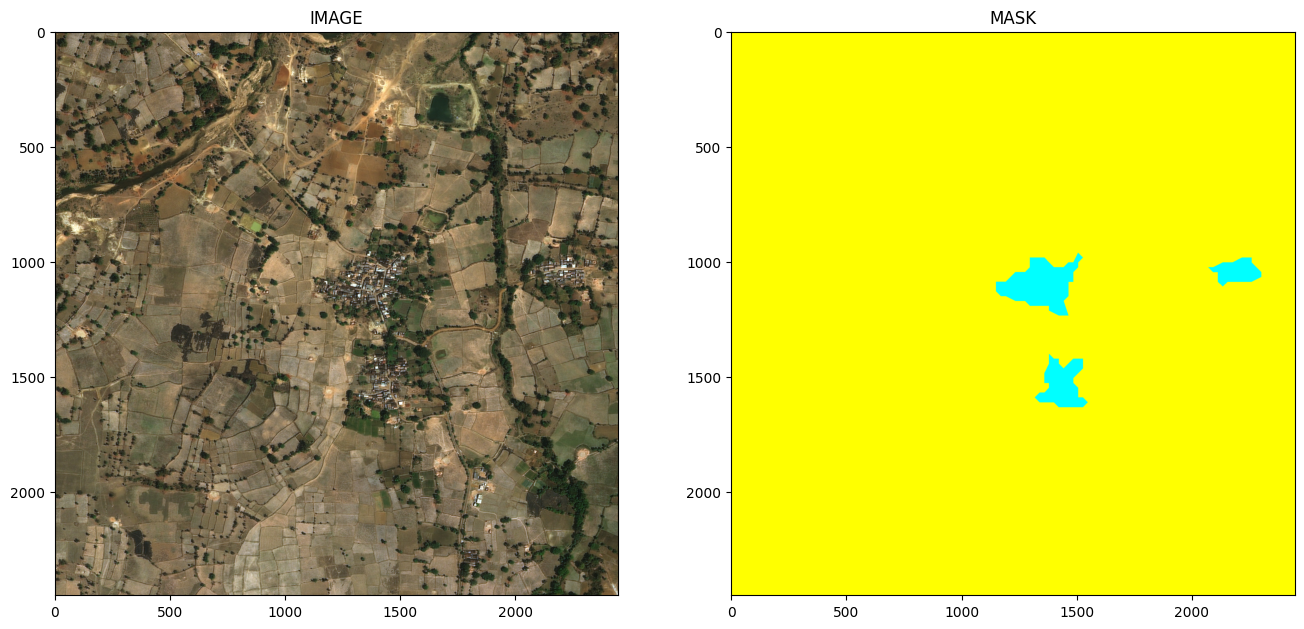

In [ ]:
index = 200

sample_img = cv2.imread(pd_train.iloc[index].IMAGES)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

sample_msk = cv2.imread(pd_train.iloc[index].MASKS)
sample_msk = cv2.cvtColor(sample_msk, cv2.COLOR_BGR2RGB)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

ax1.set_title('IMAGE')
ax1.imshow(sample_img)

ax2.set_title('MASK')
ax2.imshow(sample_msk)

In [ ]:
def rgb2category(rgb_mask):
    category_mask = np.zeros(rgb_mask.shape[:2], dtype=np.int8)
    for i, row in color_dict.iterrows():
        category_mask += (np.all(rgb_mask.reshape((-1, 3)) == (row['r'], row['g'], row['b']), axis=1).reshape(rgb_mask.shape[:2]) * i)
    return category_mask

def category2rgb(category_mask):
    rgb_mask = np.zeros(category_mask.shape[:2] + (3,))
    for i, row in color_dict.iterrows():
        rgb_mask[category_mask==i] = (row['r'], row['g'], row['b'])
    return np.uint8(rgb_mask)

In [ ]:
import albumentations as aug

train_augment = aug.Compose([
    aug.Resize(IMAGE_SIZE, IMAGE_SIZE),
    aug.HorizontalFlip(p=0.5),
    aug.VerticalFlip(p=0.5),
    aug.RandomBrightnessContrast(p=0.3)
])

test_augment = aug.Compose([
    aug.Resize(IMAGE_SIZE, IMAGE_SIZE),
    aug.RandomBrightnessContrast(p=0.3)
])

In [ ]:
from torch.utils.data import Dataset, DataLoader

class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations=None):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        row = self.df.iloc[index]

        image = cv2.imread(row.IMAGES)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(row.MASKS)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        mask = rgb2category(mask)

        image = np.transpose(image, (2, 0, 1)).astype(np.float64)
        mask = np.expand_dims(mask, axis=0)

        image = torch.Tensor(image) / 255.0
        mask = torch.Tensor(mask).long()

        return image, mask

In [ ]:
class SegmentationDataModule(pl.LightningDataModule):
    def __init__(self, pd_train, pd_val, pd_test, batch_size=10):
        super().__init__()
        self.pd_train = pd_train
        self.pd_val = pd_val
        self.pd_test = pd_test
        self.batch_size=batch_size

    def setup(self, stage=None):
        self.train_dataset = SegmentationDataset(self.pd_train, train_augment)
        self.val_dataset = SegmentationDataset(self.pd_val, test_augment)
        self.test_dataset = SegmentationDataset(self.pd_test, test_augment)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=1)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=1)

In [ ]:
data_module = SegmentationDataModule(pd_train, pd_val, pd_test, batch_size=BATCH_SIZE)
data_module.setup()

In [ ]:
image, mask = next(iter(data_module.train_dataloader()))
image.shape, mask.shape

(torch.Size([16, 3, 320, 320]), torch.Size([16, 1, 320, 320]))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pooling = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pooling(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class DoubleConvSE(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConvSE, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            SEBlock(out_channels)
        )

    def forward(self, x):
        return self.double_conv(x)

class DownBlockSE(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlockSE, self).__init__()
        self.double_conv = DoubleConvSE(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return down_out, skip_out

class UpBlockSE(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlockSE, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels - out_channels, in_channels - out_channels,
                                                kernel_size=2, stride=2)
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConvSE(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

class UNetSE(nn.Module):
    def __init__(self, out_classes=2, up_sample_mode='conv_transpose'):
        super(UNetSE, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlockSE(3, 64)
        self.down_conv2 = DownBlockSE(64, 128)
        self.down_conv3 = DownBlockSE(128, 256)
        self.down_conv4 = DownBlockSE(256, 512)
        # Bottleneck
        self.double_conv = DoubleConvSE(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlockSE(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlockSE(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlockSE(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlockSE(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

# Example usage:
#num_classes = 2
#model = UNetSE(out_classes=num_classes)



# Get UNet model
#model = UNet()


In [ ]:
#from segmentation_models_pytorch import Unet3Plus
from segmentation_models_pytorch.losses import DiceLoss, SoftCrossEntropyLoss
from segmentation_models_pytorch.metrics import get_stats, iou_score, accuracy, precision, recall, f1_score

class SegmentationModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        #self.model = UNet()  # Instantiate your U-Net model here
        self.model = UNetSE(out_classes=len(CLASSES))
        self.criterion =DiceLoss(mode="multiclass", from_logits=False)
        #self.criterion = nn.CrossEntropyLoss()

    def forward(self, inputs, targets=None):
        outputs = self.model(inputs)
        if targets is not None:
            loss = self.criterion(outputs, targets)
            tp, fp, fn, tn = get_stats(outputs.argmax(dim=1).unsqueeze(1).type(torch.int64), targets, mode='multiclass', num_classes=len(CLASSES))
            metrics = {
                "Accuracy": accuracy(tp, fp, fn, tn, reduction="micro-imagewise"),
                "IoU": iou_score(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Precision": precision(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Recall": recall(tp, fp, fn, tn, reduction="micro-imagewise"),
                "F1score": f1_score(tp, fp, fn, tn, reduction="micro-imagewise")
            }
            return loss, metrics, outputs
        else:
            return outputs

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.0001)

    def training_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "train/Loss": loss,
            "train/IoU": metrics['IoU'],
            "train/Accuracy": metrics['Accuracy'],
            "train/Precision": metrics['Precision'],
            "train/Recall": metrics['Recall'],
            "train/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "val/Loss": loss,
            "val/IoU": metrics['IoU'],
            "val/Accuracy": metrics['Accuracy'],
            "val/Precision": metrics['Precision'],
            "val/Recall": metrics['Recall'],
            "val/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "test/Loss": loss,
            "test/IoU": metrics['IoU'],
            "test/Accuracy": metrics['Accuracy'],
            "test/Precision": metrics['Precision'],
            "test/Recall": metrics['Recall'],
            "test/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

In [ ]:
!pip install torchinfo

In [ ]:
import torch

# Choose the device based on GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = SegmentationModel()
model = model.to(device)  # Move the model to the desired device (e.g., 'cuda' for GPU)

from torchinfo import summary
summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE), device=device)


Layer (type:depth-idx)                                  Output Shape              Param #
SegmentationModel                                       [16, 7, 320, 320]         --
├─UNetSE: 1-1                                           [16, 7, 320, 320]         --
│    └─DownBlockSE: 2-1                                 [16, 64, 160, 160]        --
│    │    └─DoubleConvSE: 3-1                           [16, 64, 320, 320]        39,488
│    │    └─MaxPool2d: 3-2                              [16, 64, 160, 160]        --
│    └─DownBlockSE: 2-2                                 [16, 128, 80, 80]         --
│    │    └─DoubleConvSE: 3-3                           [16, 128, 160, 160]       224,000
│    │    └─MaxPool2d: 3-4                              [16, 128, 80, 80]         --
│    └─DownBlockSE: 2-3                                 [16, 256, 40, 40]         --
│    │    └─DoubleConvSE: 3-5                           [16, 256, 80, 80]         894,464
│    │    └─MaxPool2d: 3-6                    

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val/F1score",
    mode="min"
)

logger = CSVLogger("lightning_logs", name="landcover-classification-log")

early_stopping_callback = EarlyStopping(monitor="val/Accuracy", patience=5)

trainer = pl.Trainer(
    logger=logger,
    log_every_n_steps=31,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=EPOCHS,
    accelerator="gpu",
    devices=1
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type     | Params
---------------------------------------
0 | model     | UNetSE   | 37.2 M
1 | criterion | DiceLoss | 0     
---------------------------------------
37.2 M    Trainable params
0         Non-trainable params
37.2 M    Total params
148.727   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 31: 'val/F1score' reached 0.53080 (best 0.53080), saving model to '/content/checkpoints/best-checkpoint-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 62: 'val/F1score' reached 0.47709 (best 0.47709), saving model to '/content/checkpoints/best-checkpoint-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 93: 'val/F1score' reached 0.44207 (best 0.44207), saving model to '/content/checkpoints/best-checkpoint-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 124: 'val/F1score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 155: 'val/F1score' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
trainer.test(model, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/Accuracy       │     0.872115433216095     │
│       test/F1score        │    0.5524039268493652     │
│         test/IoU          │    0.42490389943122864    │
│         test/Loss         │      -570993737728.0      │
│      test/Precision       │    0.5524039268493652     │
│        test/Recall        │    0.5524039268493652     │
└───────────────────────────┴───────────────────────────┘

[{'test/Loss': -570993737728.0,
  'test/IoU': 0.42490389943122864,
  'test/Accuracy': 0.872115433216095,
  'test/Precision': 0.5524039268493652,
  'test/Recall': 0.5524039268493652,
  'test/F1score': 0.5524039268493652}]

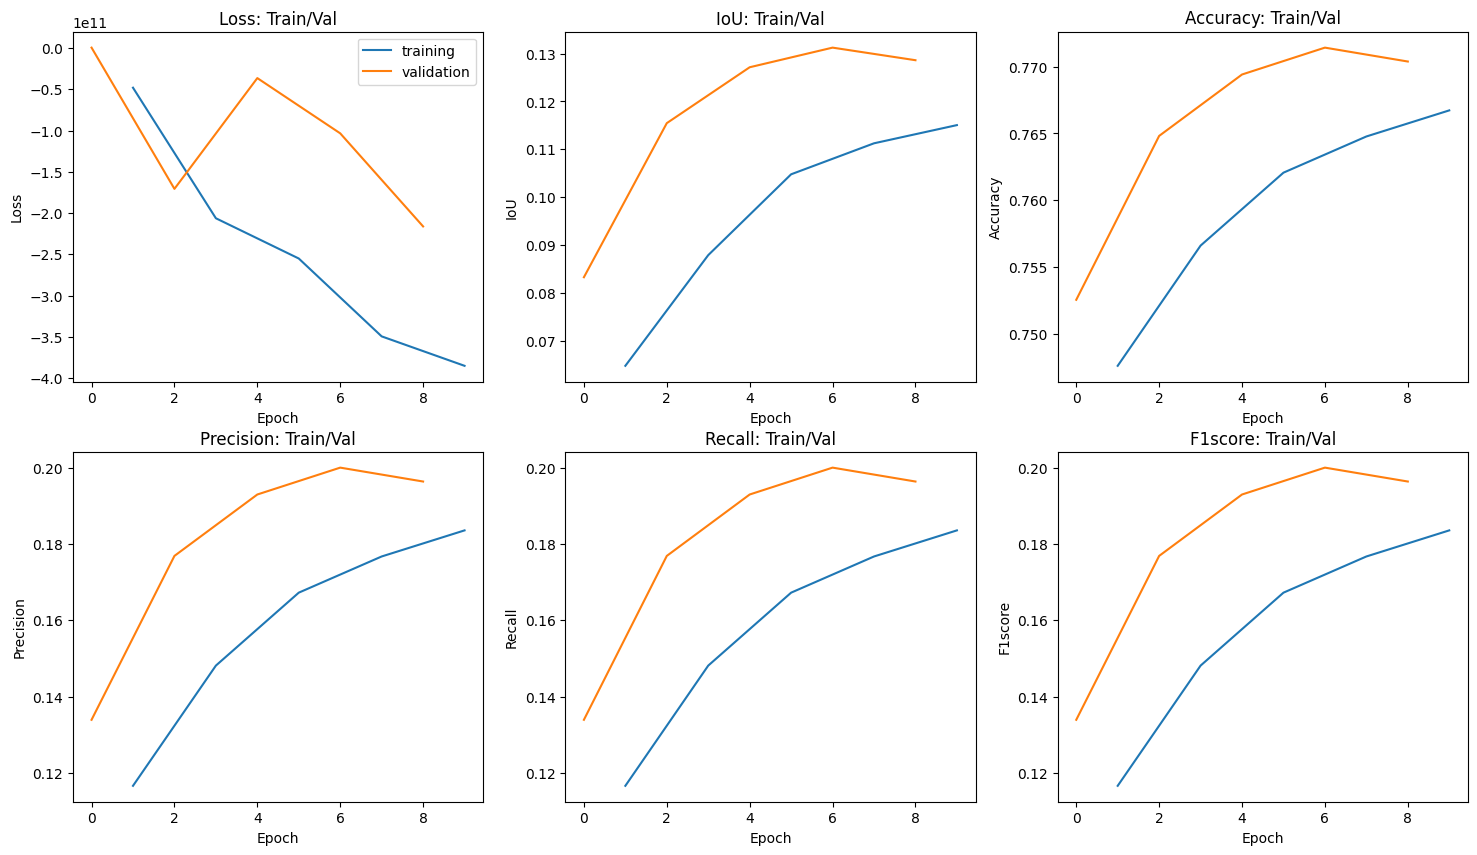

In [ ]:
metrics = pd.read_csv("./lightning_logs/landcover-classification-log/version_0/metrics.csv")
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 10))

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
names = ['Loss', 'IoU', 'Accuracy', 'Precision', 'Recall', 'F1score']

for axis, name in zip(axes, names):
    axis.plot(metrics[f'train/{name}'].dropna())
    axis.plot(metrics[f'val/{name}'].dropna())
    axis.set_title(f'{name}: Train/Val')
    axis.set_ylabel(name)
    axis.set_xlabel('Epoch')
    ax1.legend(['training', 'validation'], loc="upper right")

In [ ]:
def visualize_segmentation(original_image, ground_truth_mask, predicted_mask):
    """
    Visualize the original image, ground truth mask, and predicted mask.
    """
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Normalize masks to [0, 1]
    gt_mask_normalized = ground_truth_mask / 255.0
    pred_mask_class_0_normalized = predicted_mask / 255.0

    axes[1].imshow(gt_mask_normalized, cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    axes[2].imshow(pred_mask_class_0_normalized, cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    plt.show()

# Assuming you have `model` defined and trained
model.eval()

# Iterate through all samples in the test dataset
for sample_index in range(10):
    # Load the sample from the test dataset
    image, mask = data_module.test_dataset[sample_index]

    # Expand dimensions to match the batch format
    image = image.unsqueeze(0)

    # Get the ground truth mask for visualization
    gt_mask = mask.squeeze().numpy()

    # Get the predicted mask using the trained model
    with torch.no_grad():
        pred_mask = model(image)
        pred_mask_class_0 = pred_mask[0, 0, :, :].cpu().numpy()

    # Convert to RGB for visualization
    image_vis_rgb = (image.squeeze().permute(1, 2, 0).numpy() * 255).astype(np.uint8)

    # Ensure the correct shape for visualization
    image_vis_rgb = np.squeeze(image_vis_rgb).astype(np.uint8)

    # Visualize
    visualize_segmentation(
        original_image=image_vis_rgb,
        ground_truth_mask=gt_mask,
        predicted_mask=pred_mask_class_0
    )


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from matplotlib.colors import ListedColormap

def visualize_segmentation(original_image, ground_truth_mask, predicted_mask, class_colors, category_to_rgb):
    """
    Visualize the original image, ground truth mask, and predicted mask with color.
    """
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Convert ground truth mask to RGB using category_to_rgb
    gt_mask_rgb = category_to_rgb(ground_truth_mask, class_colors)
    axes[1].imshow(gt_mask_rgb)
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    # Convert predicted mask to RGB using category_to_rgb
    #pred_mask_rgb = category_to_rgb(predicted_mask, class_colors)
    axes[2].imshow(predicted_mask)
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    plt.show()

# Assuming you have `model` defined and trained
model.eval()

# Define class colors using the color dictionary
class_colors = ListedColormap([(row['r']/255, row['g']/255, row['b']/255) for i, row in color_dict.iterrows()])

# Function to convert category mask to RGB
def category_to_rgb(category_mask, class_colors):
    rgb_mask = class_colors(category_mask)
    return rgb_mask

# Iterate through all samples in the test dataset
for sample_index in range(10):
    # Load the sample from the test dataset
    image, mask = data_module.test_dataset[sample_index]

    # Expand dimensions to match the batch format
    image = image.unsqueeze(0)

    # Get the ground truth mask for visualization
    gt_mask = mask.squeeze().numpy()

    # Get the predicted mask using the trained model
    with torch.no_grad():
        pred_mask = model(image)
        pred_mask_class_0 = pred_mask[0, 0, :, :].cpu().numpy()

    # Convert to RGB for visualization
    image_vis_rgb = (image.squeeze().permute(1, 2, 0).numpy() * 255).astype(np.uint8)

    # Ensure the correct shape for visualization
    image_vis_rgb = np.squeeze(image_vis_rgb).astype(np.uint8)

    # Visualize with color
    visualize_segmentation(
        original_image=image_vis_rgb,
        ground_truth_mask=gt_mask,
        predicted_mask=pred_mask_class_0,
        class_colors=class_colors,
        category_to_rgb=category_to_rgb
    )


Output hidden; open in https://colab.research.google.com to view.